In [34]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

from utils_io import read_bitarrays
from utils_plot import plot_likelihood_ratio_statistics, plot_receiver_operating_characteristics_curve
from utils_attacker_lrt import likelihood_ratio_statistic_beacon_optimized, likelihood_ratio_test_threshold, likelihood_ratio_test

In [35]:
false_positive_rate = 0.05
num_snps = 1338843

In [36]:
genomes_beacon = read_bitarrays("../data/test/In_Pop.pkl")[:, :num_snps] 
genomes_reference = read_bitarrays("../data/test/Not_In_Pop.pkl")[:, :num_snps]
genomes = np.concatenate((genomes_beacon, genomes_reference), axis=0)

In [37]:
labels_beacon = np.ones(genomes_beacon.shape[0], dtype=bool)
labels_reference = np.zeros(genomes_reference.shape[0], dtype=bool)
labels = np.concatenate((labels_beacon, labels_reference), axis=0)

In [38]:
minor_allele_presences_beacon = np.any(genomes_beacon, axis=0)
minor_allele_frequencies_reference = np.mean(genomes, axis=0)

In [39]:
likelihood_ratio_statistics_beacon = likelihood_ratio_statistic_beacon_optimized(
    target_genomes=genomes_beacon,
    beacon_presences=minor_allele_presences_beacon,
    reference_frequencies=minor_allele_frequencies_reference,
    num_beacon_genomes=genomes_beacon.shape[0])
likelihood_ratio_statistics_reference = likelihood_ratio_statistic_beacon_optimized(
    target_genomes=genomes_reference,
    beacon_presences=minor_allele_presences_beacon,
    reference_frequencies=minor_allele_frequencies_reference,
    num_beacon_genomes=genomes_beacon.shape[0])
likelihood_ratio_statistics = np.concatenate((likelihood_ratio_statistics_beacon, likelihood_ratio_statistics_reference), axis=0)

In [40]:
threshold = likelihood_ratio_test_threshold(
    likelihood_ratio_statistics=likelihood_ratio_statistics,
    labels=labels,
    false_positive_rate=false_positive_rate)

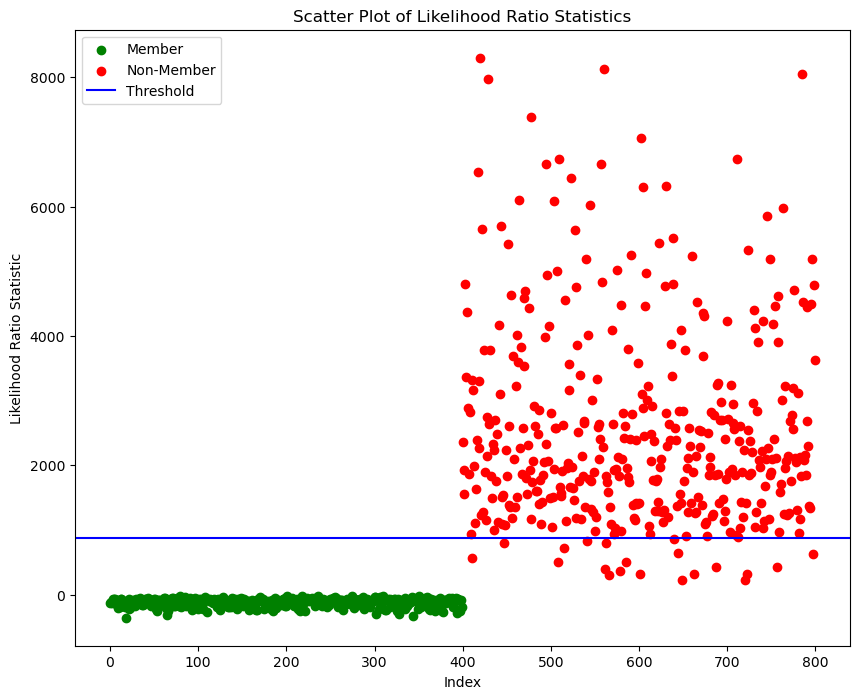

In [41]:
plot_likelihood_ratio_statistics(
    likelihood_ratio_statistics=likelihood_ratio_statistics,
    membership_labels=labels,
    threshold=threshold)

In [42]:
inverted = np.mean(likelihood_ratio_statistics_beacon) < np.mean(likelihood_ratio_statistics_reference)
predicted = likelihood_ratio_test(
    likelihood_ratio_statistics=likelihood_ratio_statistics,
    threshold=threshold,
    inverted=inverted)

In [43]:
accuracy = accuracy_score(labels, predicted)
precision = precision_score(labels, predicted)
recall = recall_score(labels, predicted)
f1 = f1_score(labels, predicted)
roc_auc = roc_auc_score(labels, 1-likelihood_ratio_statistics)
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1: {f1:.2f}")
print(f"ROC AUC: {roc_auc:.2f}")

Accuracy: 0.97
Precision: 0.95
Recall: 1.00
F1: 0.98
ROC AUC: 1.00


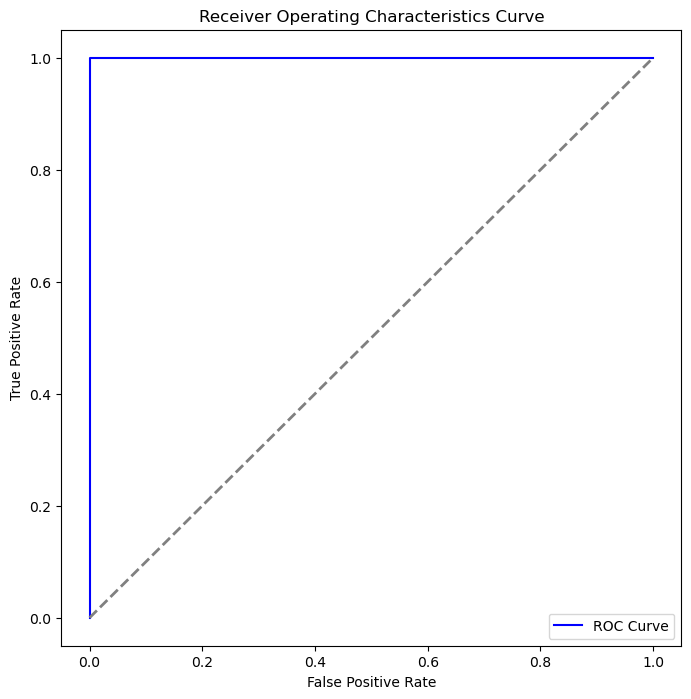

In [44]:
fpr, tpr, _ = roc_curve(labels, 1-likelihood_ratio_statistics)
plot_receiver_operating_characteristics_curve(fpr, tpr)